Objetivo: realizar uma mini análise exploratória de dados para praticar os conceitos básicos aprendidos sobre PySpark. 

Base utilizada: flights. 

Fonte: datasets do databricks.

Atributos da tabela: 
* delay: tempo de atraso dos vôos. Valores negativos indicam que o vôo chegou antes da hora prevista.
* distance: distância entre cidade de origem e destino (falta confirmar qual é a unidade de medição)
* origin: cidade de onde partiu o vôo
* destination: cidade de destino do vôo

In [ ]:
import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm

Importando base de dados:

In [ ]:
file_location = "dbfs:/databricks-datasets/flights/"
file_type = "csv"
infer_Schema = True
header = True
sep = ","

In [ ]:
df = spark.read.format(file_type) \
  .option("inferSchema", infer_Schema) \
  .option("header", header) \
  .option("sep", sep) \
  .load(file_location)
df.show(5)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 5 rows



In [ ]:
display(f'Dataframe size: {df.count()} rowns, {len(df.columns)} columns')

'Dataframe size: 1392106 rowns, 5 columns'

---

#### Limpeza e Transformação dos dados:

In [ ]:
# Transformação do tipo de dado e exclusão da coluna "date"
df = df.withColumn("delay", df["delay"].cast(T.IntegerType())) \
       .withColumn("distance", df["distance"].cast(T.FloatType())) \
       .drop("date")

In [ ]:
# Valores nulos e faltantes
def counterNullValues():
    return {col:df.filter(df[col].isNull()).count() for col in df.columns}

print(f'Before removing values: {counterNullValues()}')
df = df.na.drop()
print(f'After removing values: {counterNullValues()}')

Before removing values: {'delay': 528, 'distance': 528, 'origin': 528, 'destination': 528}
After removing values: {'delay': 0, 'distance': 0, 'origin': 0, 'destination': 0}


___

#### Exploração do conjunto de dados

Quantos destinos e origens diferentes?

In [ ]:
columns_name = ["origin", "destination"]
df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in columns_name)).show()

+------+-----------+
|origin|destination|
+------+-----------+
|   255|        303|
+------+-----------+



___

Quais os 10 destinos e origens mais comuns?

In [ ]:
# Declaração das fn e variáveis
calculate_percent = lambda col_name: ((F.col(col_name)/df.count())*100).cast(T.FloatType())
def returnTopValues(col_name, top_number):
    return df.groupBy(col_name).count() \
              .orderBy(F.col("count").desc()) \
              .limit(top_number) \
              .withColumn(f'%{col_name}', F.round(calculate_percent("count"),2))

In [ ]:
top_number = 10
top_origin = returnTopValues("origin", top_number).toPandas()
top_destination = returnTopValues("destination", top_number).toPandas()

Out[99]: Text(0.5, 1.0, '\n Main origin and destinations cities\n')

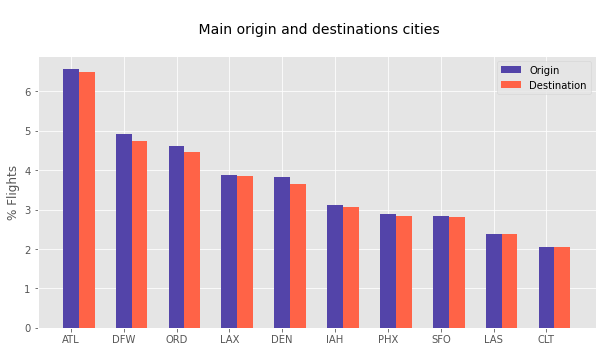

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize = (10,5))
n_groups = np.arange(len(top_origin))
plt.bar(top_origin["origin"], top_origin["%origin"], label="Origin", color='#5344A9', width=0.30)
plt.bar([x+0.30 for x in n_groups], top_destination["%destination"], label="Destination", color='tomato', width=0.30)
plt.ylabel("% Flights")
plt.legend()
plt.title('\n Main origin and destinations cities\n',fontdict = {'fontsize':14})

Vamos unir os dataframes de origem e destino, caso queiramos ver também os dados absolutos em uma tabela:

In [ ]:
cols = ["origin", "%origin", "destination", "%destination", "count"]
all_data = top_origin[cols[0:2]].merge(top_destination[cols[2:4]], 
                                       left_on=cols[0], 
                                       right_on=cols[2]).drop([cols[2]], axis=1)
all_data

,origin,%origin,%destination
0,ATL,6.57,6.50
1,DFW,4.92,4.75
2,ORD,4.62,4.45
3,LAX,3.89,3.85
4,DEN,3.82,3.66
5,IAH,3.12,3.07
6,PHX,2.89,2.85
7,SFO,2.84,2.80
8,LAS,2.38,2.37
9,CLT,2.04,2.04


Qual é o tempo médio de atraso para os destinos mais comuns?

In [ ]:
grouped_destination = df.groupBy("destination").agg(F.mean("delay").alias("mean_delay"), F.count("destination").alias("count"))
delay_main_destination = grouped_destination.orderBy(F.col("count").desc()).limit(10).orderBy(F.col("mean_delay").desc()).toPandas()

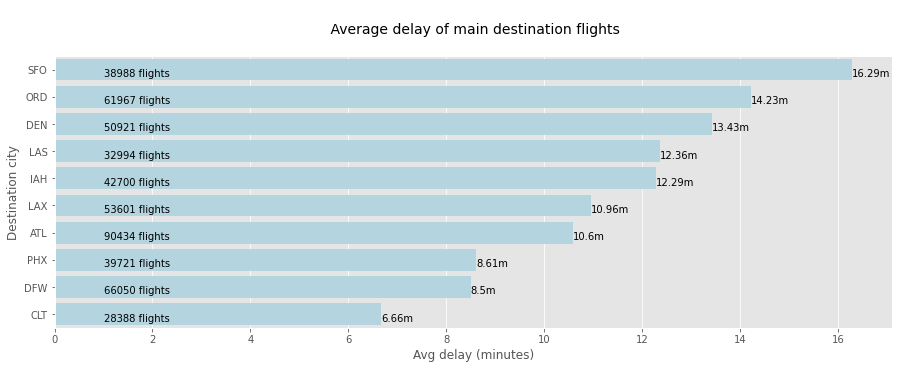

In [ ]:
#Gráfico
plt.figure(figsize = (15,5))
sns.barplot(y=delay_main_destination["destination"], x=delay_main_destination["mean_delay"], color='lightblue')
plt.ylabel('Destination city')             
plt.xlabel('Avg delay (minutes)')
plt.title('\n Average delay of main destination flights\n',fontdict = {'fontsize':14})

#Anotações
for i in range(len(delay_main_destination["destination"])):
    plt.text(1,i + 0.25, f'{delay_main_destination["count"][i]} flights')
    plt.text(delay_main_destination["mean_delay"][i], i+0.25, f'{round(delay_main_destination["mean_delay"][i],2)}m')

___

Qual a %vôos que chegaram exatamente no horário?

In [ ]:
total_flights = df.count()
no_delayed_flights = df.filter(df["delay"] == 0).count()
print(f'%flights with no delay: {no_delayed_flights/total_flights*100}')

%flights with no delay: 9.42254045407444


Qual é o tempo de atraso médio, mínimo e máximo, considerando todos os vôos?
Valores negativos indicam que o vôo chegou antes do horário previsto:

In [ ]:
print("Total delay (in minutes)")
df.select(F.round(F.avg('delay'),2).alias("Total mean"),
       F.min('delay').alias("Total min"), 
       F.max('delay').alias("Total max")).show()

Total delay (in minutes)
+----------+---------+---------+
|Total mean|Total min|Total max|
+----------+---------+---------+
|     12.08|     -112|     1642|
+----------+---------+---------+



____

Qual vôo teve o maior atraso?

In [ ]:
max_value = df.select(F.max('delay')).collect()[0][0]
df.filter(df["delay"] == max_value).show()

+-----+--------+------+-----------+
|delay|distance|origin|destination|
+-----+--------+------+-----------+
| 1642|   807.0|   TPA|        DFW|
+-----+--------+------+-----------+



_____

Quais são os 10 vôos com maior e menor média de atraso? <br><br>


Nesse caso eu estou interessada na média de atraso sempre para as mesmas rotas. Ou seja, para mesma combinação de cidade de origem e destino. Estou chamando essa combinação de "vôo". Como não temos nenhuma coluna que identifica unicamente cada vôo, irei criar uma que será a concatenação da cidade de origem + destino:

In [ ]:
df = df.withColumn("flight_SK", F.concat("origin", F.lit("_"), "destination"))

Agora, vamos checar a distribuição da contagem dos vôos:

Out[107]: <AxesSubplot:xlabel='count', ylabel='Count'>

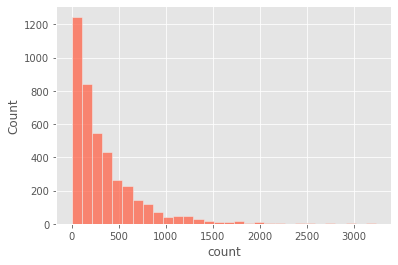

In [ ]:
grouped_avgdelay_flight = df.groupBy("flight_SK").agg(F.avg("delay").alias("mean_delay"), F.count("flight_SK").alias("count"))
sns.histplot(grouped_avgdelay_flight.toPandas()["count"], bins=30, color="tomato")

Temos muitos vôos com baixa frequência na base de dados. Para garantir que teremos uma média representativa para cada vôo, irei considerar somentes aqueles que possuem no mínimo 100 registros:

In [ ]:
grouped_avgdelay_flight = grouped_avgdelay_flight.where("count >= 100")
topRank_delay_flights = grouped_avgdelay_flight.orderBy(F.col("mean_delay").desc()).limit(10).toPandas()
bottomRank_delay_flights = grouped_avgdelay_flight.orderBy(F.col("mean_delay").asc()).limit(10).toPandas()

Agora sim, postando os gráficos dos vôos com maior e menor média de atraso:

In [ ]:
def plotDelayRank(df, color, type="top"):
    plt.figure(figsize = (16,5))
    sns.barplot(y=df["flight_SK"], x=abs(df["mean_delay"]), color=color)
    plt.ylabel('Flight')             
    plt.xlabel(f'Average {"early" if type == "bottom" else "delay"} minutes')
    plt.title(f'Flights with {"longest" if type == "top" else "less"} delay',fontdict = {'fontsize':14})

    for i in range(len(df["flight_SK"])):
        plt.text(2,i + 0.25, f'{df["count"][i]} flights', color="white")
        plt.text(abs(df["mean_delay"][i]), i+0.25, f'{round(df["mean_delay"][i],2)}m')
        

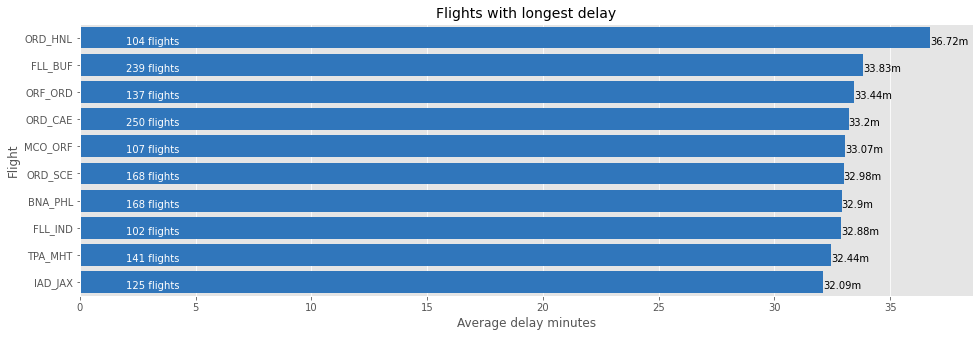

In [ ]:
plotDelayRank(topRank_delay_flights, "#1976d2")

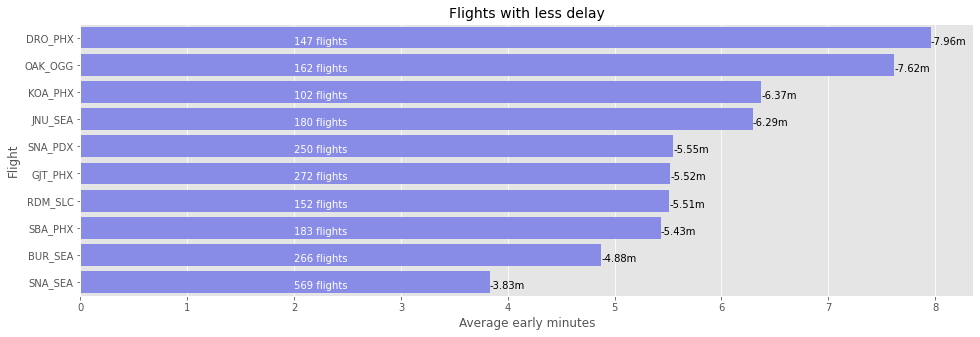

In [ ]:
plotDelayRank(bottomRank_delay_flights, "#797Ef6", "bottom")

___

Como é a distribuição do tempo de atraso? <br><br>
Para essa análise, irei categorizar os dados da coluna delay:

In [ ]:
categories_description = {
    0: "delay <= 0m",
    1: "0m > delay <= 15m",
    2: "15m > delay <= 30m",
    3: "30m > delay <= 60m",
    4: "delay > 60m"
}

In [ ]:
df = df.withColumn("delay_cat", 
              F.when(F.col("delay") <= 0, 0)
              .when((F.col("delay") > 0) & (F.col("delay") <= 15), 1)
              .when((F.col("delay") > 15) & (F.col("delay") <= 30), 2)
              .when((F.col("delay") > 30) & (F.col("delay") <= 60), 3)
              .otherwise(4))

Calculando % de cada uma das categorias:

In [ ]:
delay_categories_perc = df.groupBy("delay_cat").count() \
                            .withColumn("%delay_cat", F.round(calculate_percent("count"))) \
                            .orderBy("delay_cat") \
                            .toPandas()

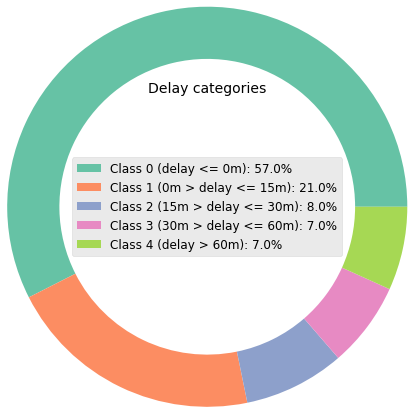

In [ ]:
#Gráfico
cat_name = delay_categories_perc["delay_cat"]
cat_values = delay_categories_perc["%delay_cat"]
cat_size = np.arange(delay_categories_perc.shape[0])

labels = [f'Class {cat_name[i]} ({categories_description[i]}): {cat_values[i]}%' for i in cat_size]
plt.pie(delay_categories_perc['count'], radius = 2.3, colors = cm.Set2(np.arange(5)), wedgeprops = dict(width = 0.6))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Delay categories", loc = 'Center', fontdict = {'fontsize':14})
plt.show()

___

Os vôos mais distantes são os que atrasam mais?

Out[116]: <AxesSubplot:title={'center':'\n Relationship between distance and delay\n'}, xlabel='\n Distance \n', ylabel='\n Delay (minutes)'>

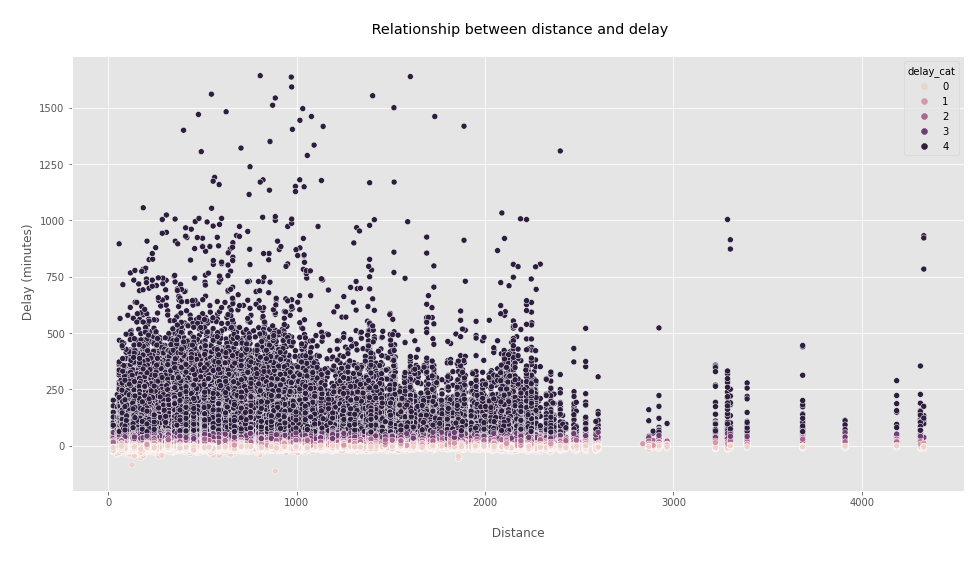

In [ ]:
pd_data = df.toPandas()
plt.figure(figsize = (16,8))
plt.ylabel('\n Delay (minutes)')
plt.xlabel('\n Distance \n')
plt.title('\n Relationship between distance and delay\n')
sns.scatterplot(data=pd_data, x="distance", y="delay", hue="delay_cat")